In [58]:
import datetime
from pathlib import Path
from typing import Dict, List, Union
import warnings
warnings.filterwarnings("ignore")
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.interpolate import griddata


%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

sns.set_style('whitegrid')
vis_path = 'Visualisation\\sqi\\'

In [59]:
def weighted_avg(x, weight, factor):    
    with warnings.catch_warnings():        
        warnings.simplefilter('ignore')        
        tmp = x[[weight, factor]].dropna()        
        weighted_sum = (tmp[weight] * tmp[factor]).sum()        
        count_sum = tmp[weight].sum()        
        return weighted_sum / count_sum

In [60]:
df=pd.read_csv('data\\sqi.csv',sep=';')
df.columns=pd.Series(df.columns).apply(str.lower)
df['event_date']=pd.to_datetime(df['event_date'])
df['event_year'] = df['event_date'].dt.year

In [61]:
dic_locus = pd.read_csv('data\\dic_locus_site_CAM.csv',encoding='windows-1252')
dic_locus = dic_locus[dic_locus.orgunitname=='UPS'] 
# dic_locus
# dic_locus.to_csv('data/dic_locus_site_CAM_UPS.csv',index=False)

In [62]:
# dic_locus[dic_locus.containername=='101M']

In [63]:
df=df.merge(dic_locus,left_on=['locus'],right_on=['containername'],how='left')
#drop not needed and NaN columns
df.drop(columns=['site','etapa_de_muestreo','alteracion_operculo','site_id','locus_group_id','containername','orgunitname','opacidad_corneal','oerculo_corto','inflamados'],inplace=True)

In [64]:
df.columns

Index(['event_date', 'locus_group', 'locus', 'fish_group', 'destino',
       'density', 'cantidad_muestreada', 'normal', 'grado_1', 'grado_2',
       'grado_3', 'cataratas', 'event_year', 'locus_id'],
      dtype='object')

In [65]:
df['grado_3']=df['grado_3'].fillna(0)
df['grado_123']=df['grado_1']+df['grado_2']+df['grado_3']

In [66]:
df.shape

(102, 15)

In [67]:
factors = [
 'density',
 'normal',
 'grado_1',
 'grado_2',
 'grado_3',
 'grado_123',
 'cataratas']

In [68]:
# df['destino'].value_counts()

In [69]:
dftar=pd.read_csv('data\\targets.csv')

swfw=pd.read_csv('data/sw_locus_fw_locus_population_with_counts.csv')
swfw['transfer_date'] = pd.to_datetime(swfw['transfer_date'])
swfw['transfer_year']= swfw.transfer_date.dt.year

swfw=swfw.merge(dftar,left_on=['to_locus_id','to_fish_group_id','transfer_year'],
           right_on=['locus_id','fish_group_id','transfer_year'],how='left')

In [70]:
# swfw[swfw.from_locus_id==3046029    ]

In [71]:
tmpdf1=pd.DataFrame(swfw[['from_locus_id','transfer_year','total_mortality_perc_90','nSFR','from_count_stocking']].groupby(['from_locus_id','transfer_year']).apply(weighted_avg, 'from_count_stocking', 'total_mortality_perc_90'))
tmpdf1.columns=['mortality']
tmpdf2=pd.DataFrame(swfw[['from_locus_id','transfer_year','total_mortality_perc_90','nSFR','from_count_stocking']].groupby(['from_locus_id','transfer_year']).apply(weighted_avg, 'from_count_stocking', 'nSFR'))
tmpdf2.columns=['nsfr']
tmpdf3=pd.DataFrame(swfw[['from_locus_id','transfer_year','from_avg_weight','from_count_stocking']].groupby(['from_locus_id','transfer_year']).apply(weighted_avg, 'from_count_stocking', 'from_avg_weight'))
tmpdf3.columns=['stocking_weight']

fw_performance=tmpdf1.merge(tmpdf2,left_index=True,right_index=True).dropna()
fw_performance=fw_performance.merge(tmpdf3,left_index=True,right_index=True)
# fw_performance.to_csv('data/fw_performance.csv')

fw_performance_=fw_performance.reset_index()
df_=df.merge(fw_performance_,left_on=['locus_id','event_year'],right_on=['from_locus_id','transfer_year'],how='left')

In [72]:
# fw_performance.hist()

In [73]:
df__=df_[~df_.mortality.isna()]
# for c in ['grado_3','inflamados','opacidad_corneal','oerculo_corto','cataratas']:
for c in ['grado_3','cataratas']:
    df__[c] = df__[c].fillna(0)

In [74]:
#filter 3 records from 2021
print(len(df__))
df_2022=df__[df__.event_year==2022]
print(len(df_2022))
#remove 5 records with wrong labeling
df_2022=df_2022[(df_2022['normal']+df_2022['grado_1']+df_2022['grado_2']+df_2022['grado_3'])>=0.98]
print(len(df_2022))
df_2022['mortality']=df_2022['mortality']*100

76
73
68


In [75]:
# df_2022#.density.describe()

In [76]:
factors

['density',
 'normal',
 'grado_1',
 'grado_2',
 'grado_3',
 'grado_123',
 'cataratas']

In [77]:
df_2022

,event_date,locus_group,locus,fish_group,destino,density,cantidad_muestreada,normal,grado_1,grado_2,grado_3,cataratas,event_year,locus_id,grado_123,from_locus_id,transfer_year,mortality,nsfr,stocking_weight
6,2022-03-07,UPS1,101H,72G2112.SNAQG2000.C4B.PH.FP,Puerto Argentino,54.44,101,0.38,0.40,0.18,0.05,0.0,2022,3047916,0.63,3047916.0,2022.0,0.382514,0.883538,272.000000
7,2022-04-07,UPS3,301M,72G2117.SNFLY2100.C2.PH,Puerto Argentino,47.00,103,0.38,0.49,0.10,0.04,0.0,2022,3048852,0.63,3048852.0,2022.0,1.094121,0.943125,176.537438
8,2022-04-07,UPS3,301M,72G2117.SNFLY2100.C2.PH,Puerto Argentino,47.00,133,0.51,0.39,0.08,0.01,0.0,2022,3048852,0.48,3048852.0,2022.0,1.094121,0.943125,176.537438
9,2022-04-07,UPS4,407H,72G2117.SNFLY2100.C2.PH,Puerto Argentino,31.85,129,0.54,0.32,0.08,0.06,0.0,2022,3049203,0.46,3049203.0,2022.0,2.165493,1.060425,162.917100
10,2022-04-07,UPS3,308M,72G2203.SNFLY2100.C2.PH.LUF,Weste Filomena,31.36,126,0.45,0.37,0.13,0.05,0.0,2022,3047319,0.55,3047319.0,2022.0,1.117080,0.901895,188.862735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2022-08-23,UPS3,302,72G2205.SNLCY2100.C4.PH,Marilmo,14.86,103,0.68,0.23,0.07,0.02,0.0,2022,3049323,0.32,3049323.0,2022.0,0.572634,1.159756,153.000000
98,2022-08-23,UPS3,304,72G2202.SNLCY2100.C3B.PH,Loncochalgua,43.01,114,0.60,0.30,0.10,0.01,0.0,2022,3048387,0.41,3048387.0,2022.0,0.459079,1.151517,161.000000
99,2022-08-23,UPS3,307,72G2202.SNLCY2100.C3B.PH,Loncochalgua,46.27,113,0.58,0.23,0.09,0.10,0.0,2022,3051257,0.42,3051257.0,2022.0,0.559962,1.047410,216.893086
100,2022-08-23,UPS4,407H,72G2202.SNLCY2100.C3B.PH,Loncochalgua,46.72,113,0.43,0.42,0.10,0.04,0.0,2022,3049203,0.56,3049203.0,2022.0,2.165493,1.060425,162.917100


In [78]:
#grouping
df_2022_=pd.DataFrame()
for factor in factors+['mortality','nsfr','stocking_weight']:
    tmpdf = pd.DataFrame(df_2022.groupby(['event_date','locus']).apply(weighted_avg, 'cantidad_muestreada', factor))
    tmpdf.columns = [factor]
    df_2022_=pd.concat([df_2022_,tmpdf],1)

In [80]:
df_2022_.corr()

,density,normal,grado_1,grado_2,grado_3,grado_123,cataratas,mortality,nsfr,stocking_weight
density,1.000000,-0.205473,0.198976,0.055745,-0.035145,0.197883,0.002948,0.063591,-0.214816,0.264362
normal,-0.205473,1.000000,-0.820465,-0.459677,-0.224198,-0.997651,-0.019600,-0.276940,0.480062,-0.169068
grado_1,0.198976,-0.820465,1.000000,-0.082628,-0.248120,0.822689,0.204874,0.457102,-0.544674,-0.148164
grado_2,0.055745,-0.459677,-0.082628,1.000000,0.501337,0.464024,-0.233313,-0.270798,0.024724,0.457782
grado_3,-0.035145,-0.224198,-0.248120,0.501337,1.000000,0.217644,-0.259219,-0.160194,0.053694,0.460306
grado_123,0.197883,-0.997651,0.822689,0.464024,0.217644,1.000000,0.028526,0.266597,-0.475630,0.165130
cataratas,0.002948,-0.019600,0.204874,-0.233313,-0.259219,0.028526,1.000000,-0.029237,-0.233045,-0.060941
mortality,0.063591,-0.276940,0.457102,-0.270798,-0.160194,0.266597,-0.029237,1.000000,-0.415515,-0.425066
nsfr,-0.214816,0.480062,-0.544674,0.024724,0.053694,-0.475630,-0.233045,-0.415515,1.000000,0.010902
stocking_weight,0.264362,-0.169068,-0.148164,0.457782,0.460306,0.165130,-0.060941,-0.425066,0.010902,1.000000


density


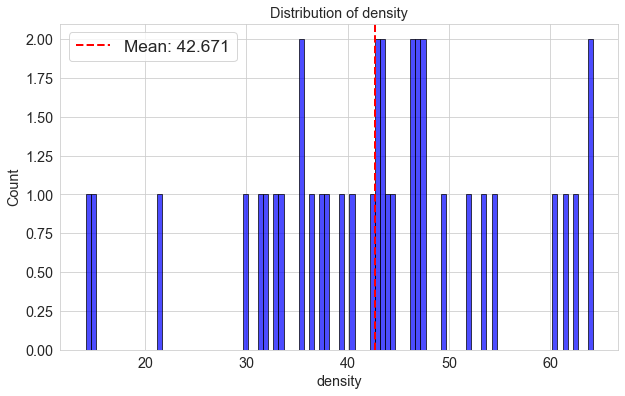

normal


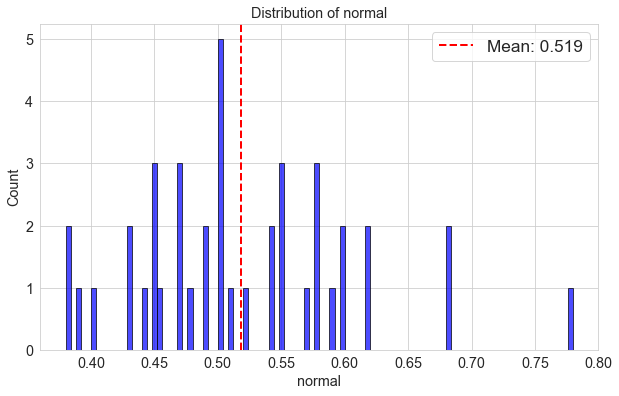

grado_1


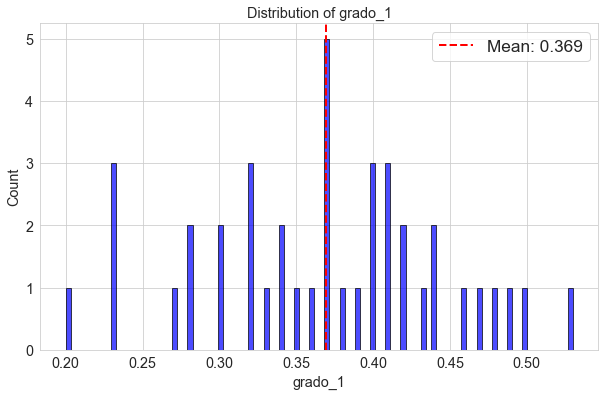

grado_2


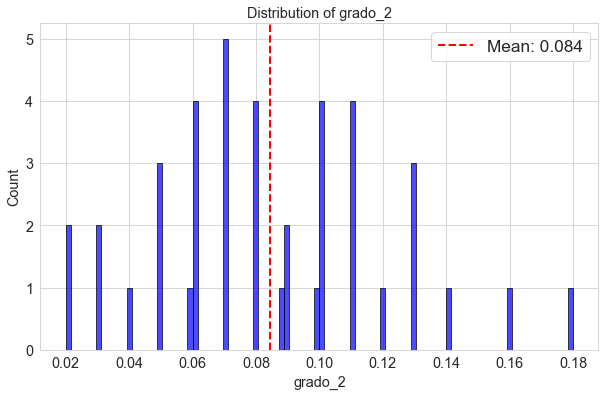

grado_3


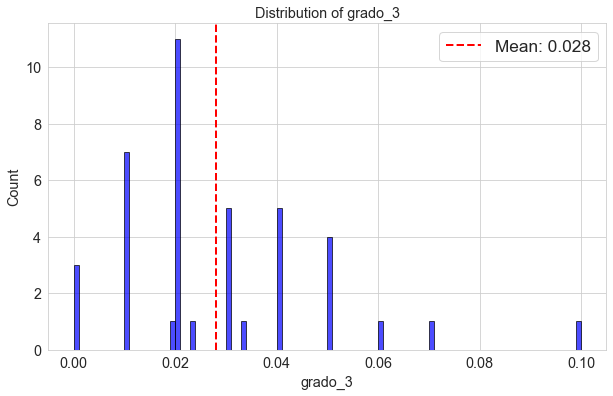

grado_123


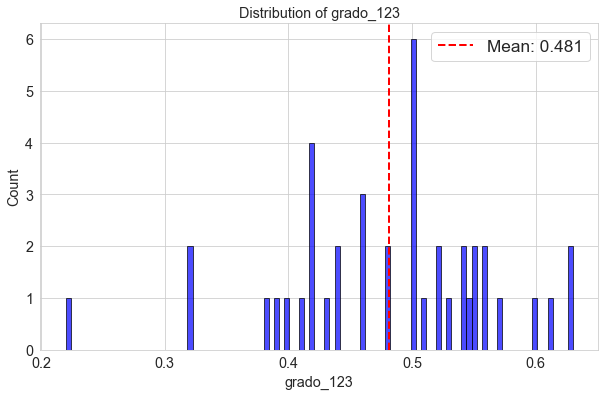

cataratas


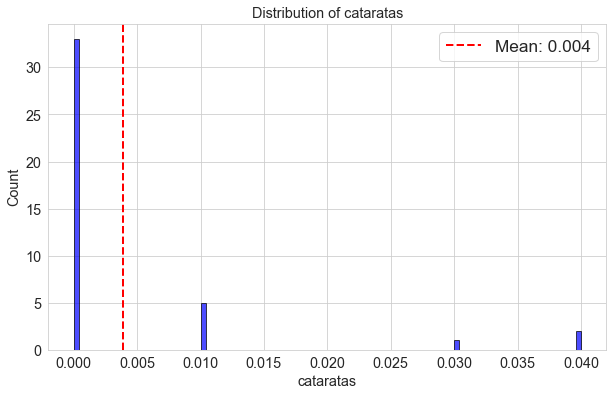

In [36]:
arr_for_chart = df_2022_.copy()
#plot histograms
for factor in factors:
    print(factor)
    plt.figure(figsize=(10, 6))
    plt.hist(arr_for_chart[factor], bins=100, alpha=0.7, color='blue', edgecolor='black')

    # Add a vertical line for the mean value
    mean_value = np.mean(arr_for_chart[factor])
    if factor =='event_date':
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value.date()}')
    else:
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.3f}')

    # Add labels and title
    plt.xlabel(factor)
    plt.ylabel('Count')
    plt.title(f'Distribution of {factor}')
    plt.legend()

    # Save the plot
    plt.savefig(vis_path + f'{factor}_histogram.jpg')

    # Show the plot
    plt.show()

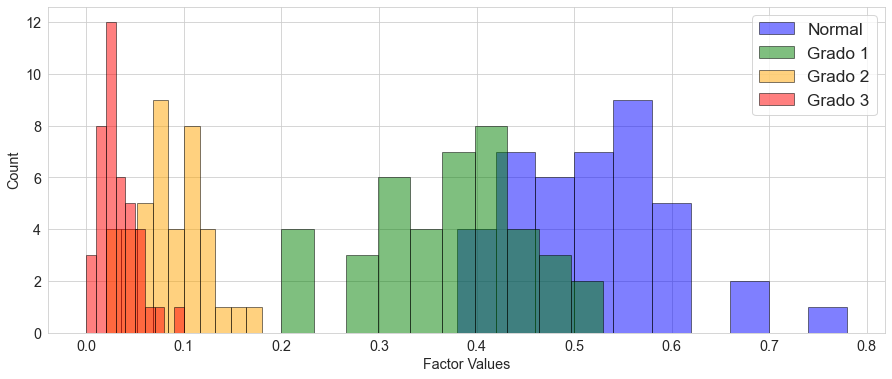

In [56]:
arr_for_chart = df_2022_.copy()

# Plot the histogram
plt.figure(figsize=(15, 6))

bins_number = 10

plt.hist(arr_for_chart['normal'], bins=bins_number, alpha=0.5, color='blue', edgecolor='black', label='Normal')
plt.hist(arr_for_chart['grado_1'], bins=bins_number, alpha=0.5, color='green', edgecolor='black', label='Grado 1')
plt.hist(arr_for_chart['grado_2'], bins=bins_number, alpha=0.5, color='orange', edgecolor='black', label='Grado 2')
plt.hist(arr_for_chart['grado_3'], bins=bins_number, alpha=0.5, color='red', edgecolor='black', label='Grado 3')

# Add labels and title
plt.xlabel('Factor Values')
plt.ylabel('Count')
# plt.title('Distribution of Different Factors')
plt.legend()

plt.savefig(vis_path + f'joint_sqi_histogram.png',dpi=300)

In [229]:
# fw_performance_[fw_performance_.from_locus_id==3047489]

In [230]:
# swfw[(swfw.from_locus_id==3047489)&(swfw.transfer_year==2022)]

In [231]:
# dfmvmt = pd.read_csv('data/evt_movement_ratio_with_dates.csv')
# dfmvmt['starttime'] = pd.to_datetime(dfmvmt['starttime'])
# dfmvmt[(dfmvmt.historic_locus_id==3047489)&(dfmvmt.starttime.dt.year==2022)].tail(20)

In [232]:
#for 26 rows target values are not defined
# df_[df_.mortality.isna()]

In [37]:
df_2022_[factors+['stocking_weight','mortality']].corr()['mortality'].sort_values()

stocking_weight   -0.425066
normal            -0.276940
grado_2           -0.270798
grado_3           -0.160194
cataratas         -0.029237
density            0.063591
grado_123          0.266597
grado_1            0.457102
mortality          1.000000
Name: mortality, dtype: float64

In [38]:
df_2022_[factors+['stocking_weight','nsfr']].corr()['nsfr'].sort_values()

grado_1           -0.544674
grado_123         -0.475630
cataratas         -0.233045
density           -0.214816
stocking_weight    0.010902
grado_2            0.024724
grado_3            0.053694
normal             0.480062
nsfr               1.000000
Name: nsfr, dtype: float64

<AxesSubplot:>

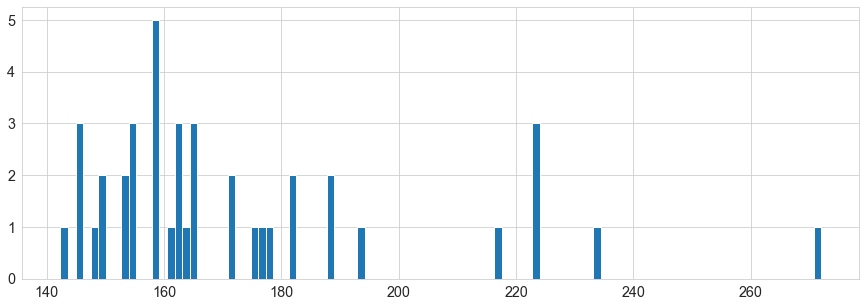

In [63]:
df_2022_.stocking_weight.hist(bins=100)

<AxesSubplot:>

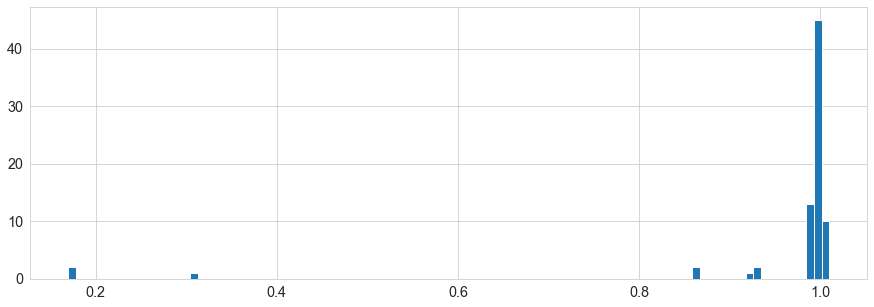

In [100]:
# (df__['normal']+df__['grado_1']+df__['grado_2']+df__['grado_3']).hist(bins=100)

density mortality
density nsfr
normal mortality
normal nsfr
grado_1 mortality
grado_1 nsfr
grado_2 mortality
grado_2 nsfr
grado_3 mortality
grado_3 nsfr
grado_123 mortality
grado_123 nsfr
cataratas mortality
cataratas nsfr
stocking_weight mortality
stocking_weight nsfr


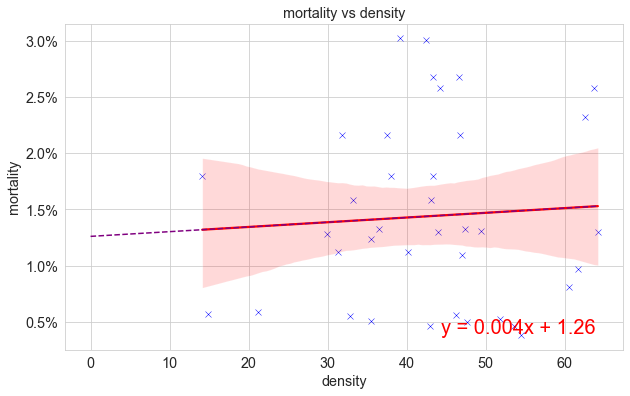

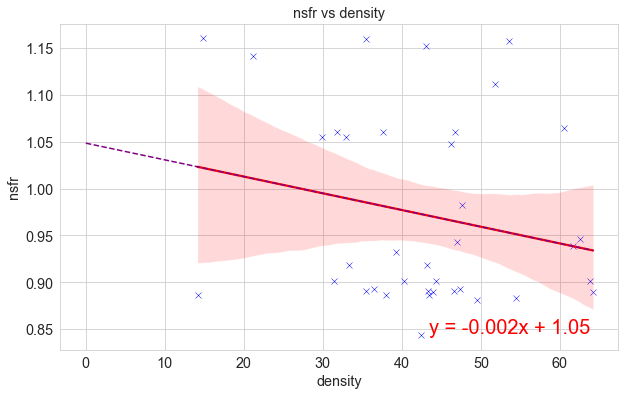

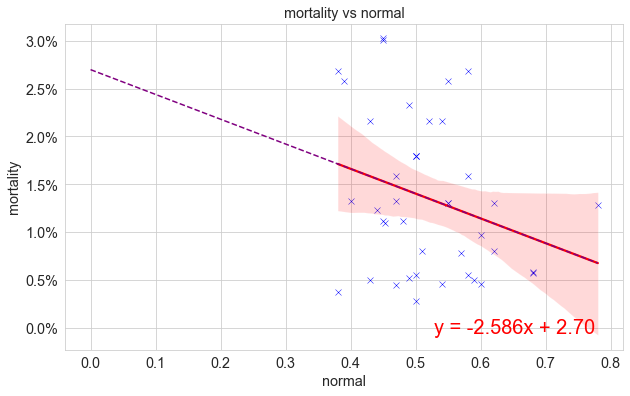

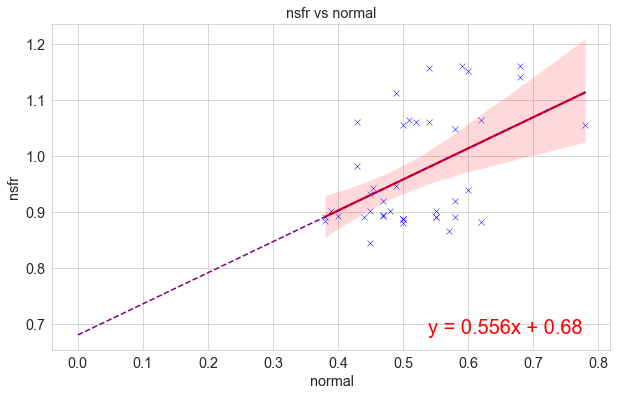

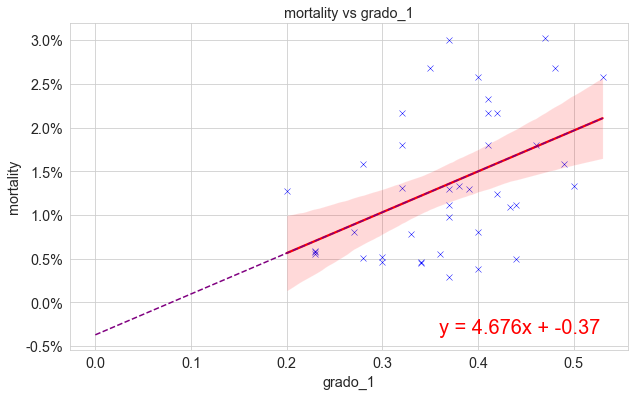

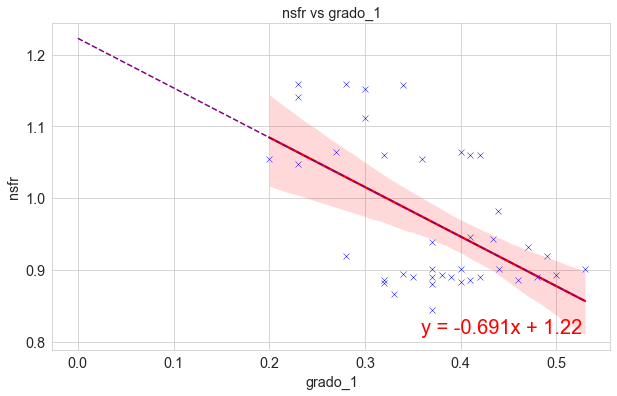

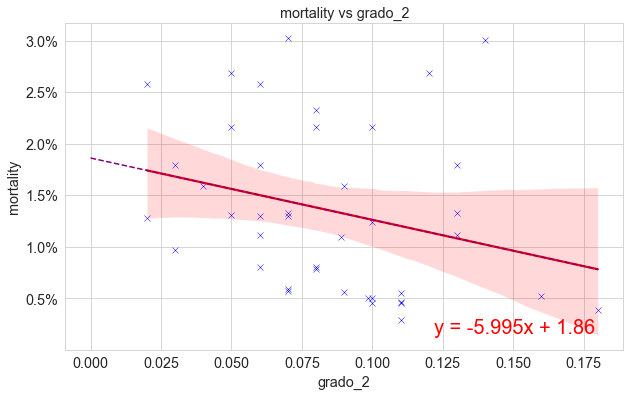

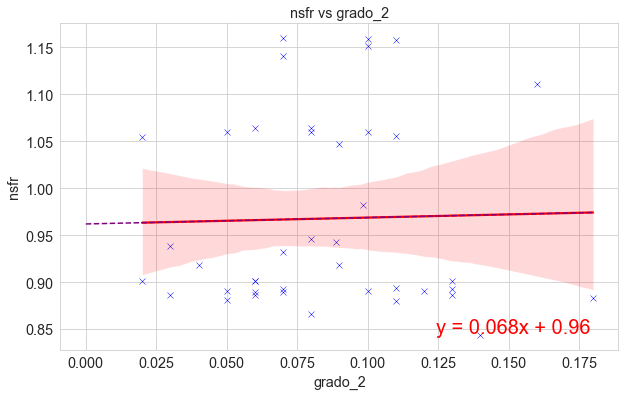

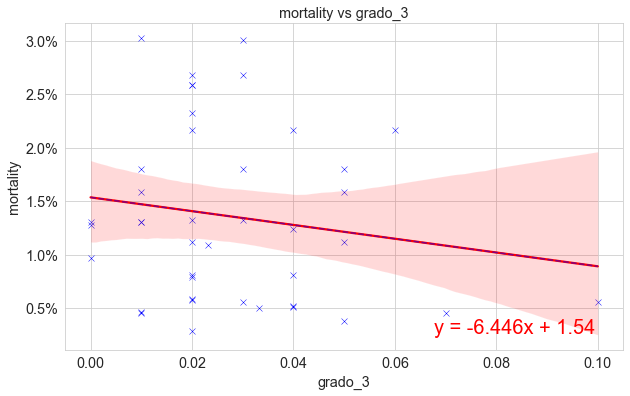

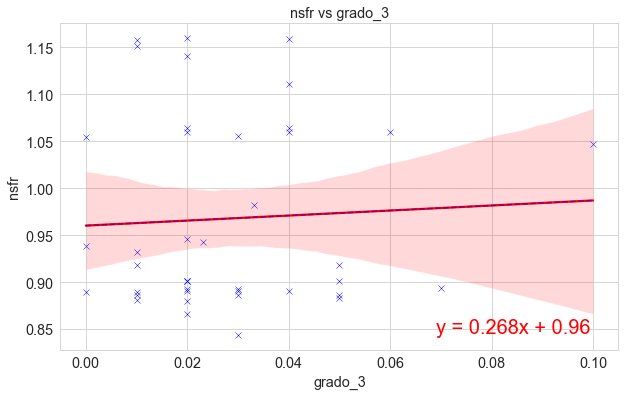

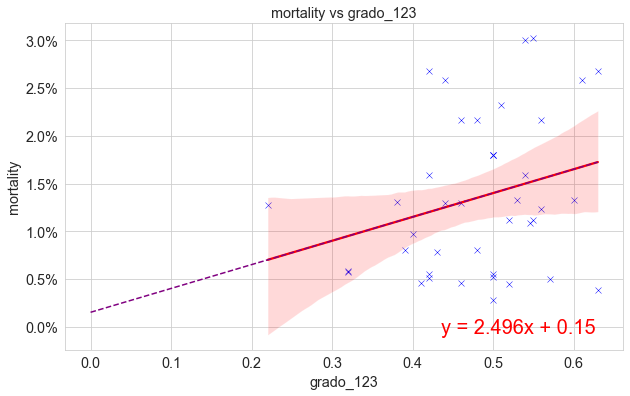

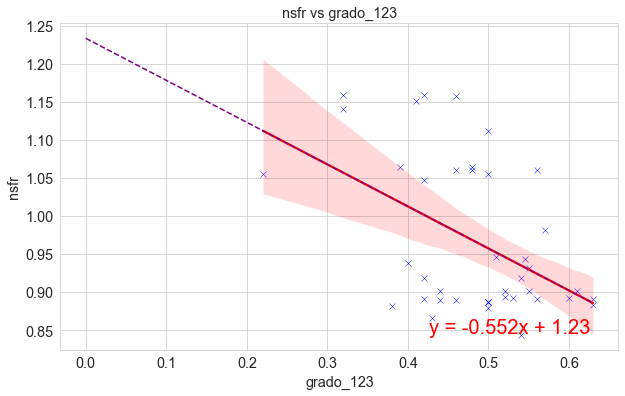

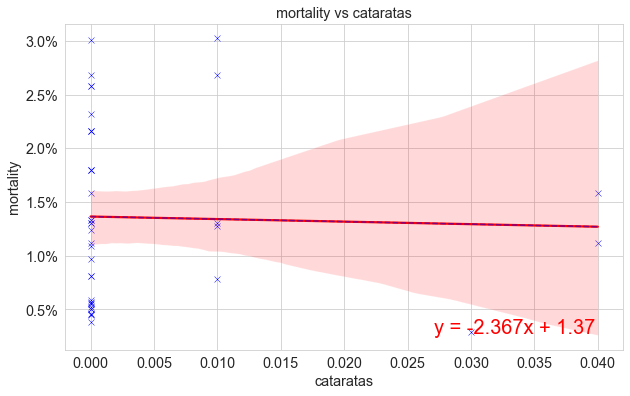

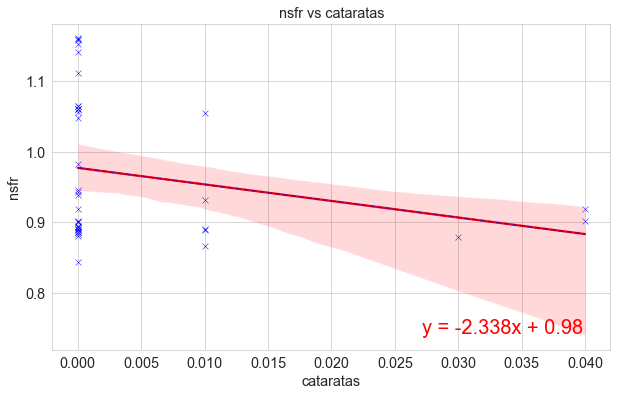

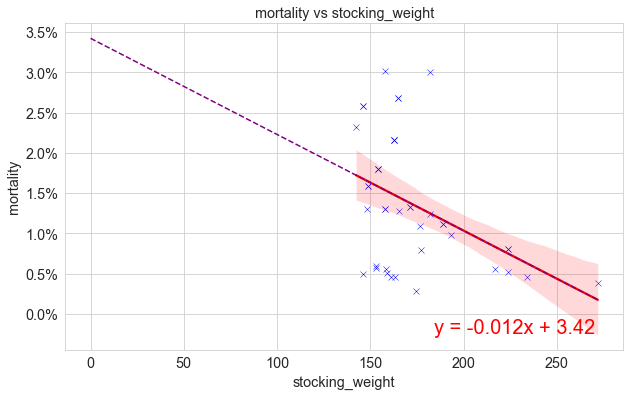

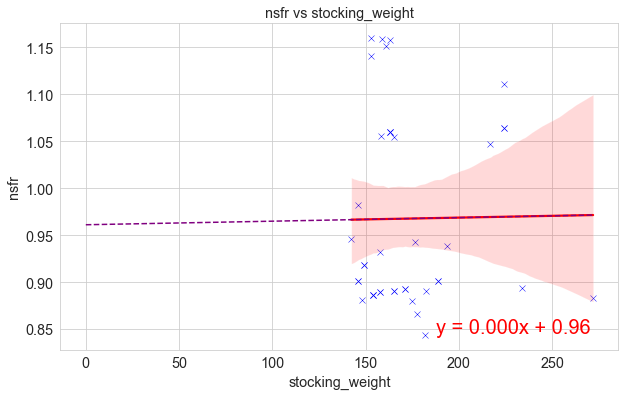

In [39]:
# Format y-axis as a percentage
def percent_formatter(x, pos):
    return f'{x:.1f}%'
factor = 'grado_1'
target = 'mortality'
for factor in factors+['stocking_weight']:
    for target in ['mortality','nsfr']:
        print(factor,target)
        arr_for_chart = df_2022_[[factor,target]].dropna()#[df__.grado_1>df__.grado_1.quantile(.05)]
        # arr_for_chart = df__[df__.stocking_weight.between(140,180)]
        # Create the scatter plot with crosses as markers
        plt.figure(figsize=(10, 6))
        scatter_plot = sns.scatterplot(data=arr_for_chart, x=factor, y=target, marker='x', color='blue')

        # Add a trendline with equation
        sns.regplot(data=arr_for_chart, x=factor, y=target, scatter=False, ax=scatter_plot, color='red', label='Trendline')

        # Get the slope and intercept for the trendline
        slope, intercept = np.polyfit(arr_for_chart[factor], arr_for_chart[target], 1)

        # Add the equation to the plot
        equation = f'y = {slope:.3f}x + {intercept:.2f}'
        plt.text(0.95, 0.05, equation, fontsize=20, transform=plt.gca().transAxes, ha='right',c='red')


        if target=='mortality':
            plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

        # Set x-axis limits and ticks
        # plt.xlim(0, 0.6)
        # plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])# Add labels and title

        # Extrapolate trendline beyond the range
        extrapolated_x = np.array([0, arr_for_chart[factor].max()])  # Your desired extrapolation range
        extrapolated_y = extrapolated_x * slope + intercept
        plt.plot(extrapolated_x, extrapolated_y, color='purple', linestyle='dashed', label='Extrapolated Trendline')


        plt.xlabel(factor)
        plt.ylabel(target)
        title = f'{target} vs {factor}'
        plt.title(title)
        # plt.legend()

        plt.savefig(vis_path + title+ f'.png',dpi=300)

In [43]:
df_2022_[factors+['mortality','nsfr','stocking_weight']].describe()

,density,normal,grado_1,grado_2,grado_3,grado_123,cataratas,mortality,nsfr,stocking_weight
count,37.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,42.670811,0.518596,0.369095,0.084322,0.027956,0.481373,0.003902,1.355870,0.967857,173.060321
std,12.175527,0.086404,0.078885,0.036453,0.020054,0.086177,0.009969,0.806950,0.100007,28.714552
min,14.140000,0.380000,0.200000,0.020000,0.000000,0.220000,0.000000,0.286807,0.844091,142.341576
25%,35.500000,0.453263,0.320000,0.060000,0.020000,0.420000,0.000000,0.572634,0.890672,154.063535
50%,43.340000,0.500000,0.370000,0.080000,0.020000,0.500000,0.000000,1.281297,0.918909,162.917100
75%,47.580000,0.580000,0.420000,0.110000,0.040000,0.540000,0.000000,1.797221,1.060425,182.000000
max,64.200000,0.780000,0.530000,0.180000,0.100000,0.630000,0.040000,3.022337,1.159756,272.000000


In [44]:
df_2022_[factors+['mortality','nsfr','stocking_weight']].corr()

,density,normal,grado_1,grado_2,grado_3,grado_123,cataratas,mortality,nsfr,stocking_weight
density,1.000000,-0.205473,0.198976,0.055745,-0.035145,0.197883,0.002948,0.063591,-0.214816,0.264362
normal,-0.205473,1.000000,-0.820465,-0.459677,-0.224198,-0.997651,-0.019600,-0.276940,0.480062,-0.169068
grado_1,0.198976,-0.820465,1.000000,-0.082628,-0.248120,0.822689,0.204874,0.457102,-0.544674,-0.148164
grado_2,0.055745,-0.459677,-0.082628,1.000000,0.501337,0.464024,-0.233313,-0.270798,0.024724,0.457782
grado_3,-0.035145,-0.224198,-0.248120,0.501337,1.000000,0.217644,-0.259219,-0.160194,0.053694,0.460306
grado_123,0.197883,-0.997651,0.822689,0.464024,0.217644,1.000000,0.028526,0.266597,-0.475630,0.165130
cataratas,0.002948,-0.019600,0.204874,-0.233313,-0.259219,0.028526,1.000000,-0.029237,-0.233045,-0.060941
mortality,0.063591,-0.276940,0.457102,-0.270798,-0.160194,0.266597,-0.029237,1.000000,-0.415515,-0.425066
nsfr,-0.214816,0.480062,-0.544674,0.024724,0.053694,-0.475630,-0.233045,-0.415515,1.000000,0.010902
stocking_weight,0.264362,-0.169068,-0.148164,0.457782,0.460306,0.165130,-0.060941,-0.425066,0.010902,1.000000


In [48]:
df_2022_[df_2022_.stocking_weight<163].grado_123.mean()

0.4709920634920636

In [49]:
df_2022_.grado_123.describe()

count    41.000000
mean      0.481373
std       0.086177
min       0.220000
25%       0.420000
50%       0.500000
75%       0.540000
max       0.630000
Name: grado_123, dtype: float64

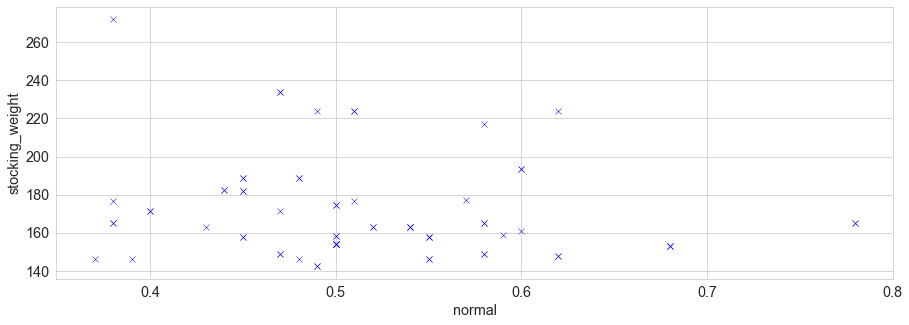

In [176]:
# scatter_plot = sns.scatterplot(data=df_2022, x='normal', y='stocking_weight', marker='x', color='blue')

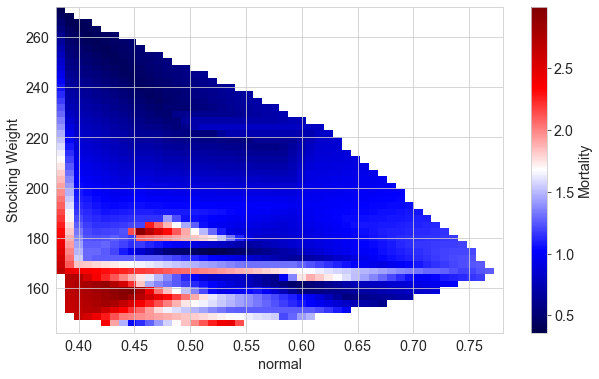

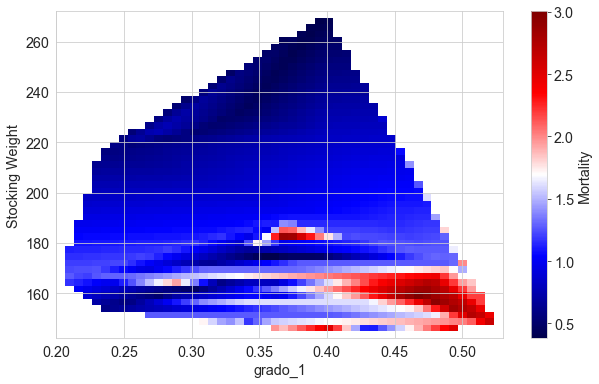

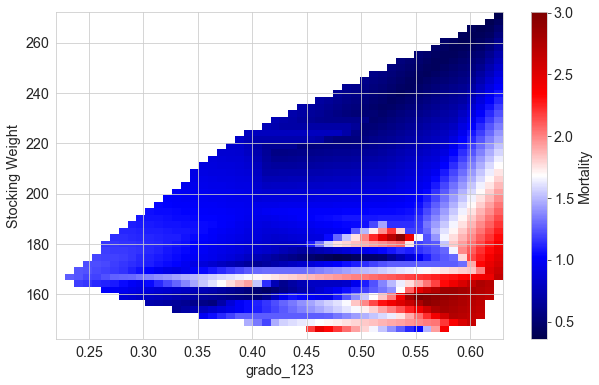

In [41]:
# factor = 'normal'
for factor in ['normal','grado_1','grado_123']:
    arr_for_3dchart_ = df_2022_[[factor,'stocking_weight','mortality']].dropna()
    grid_step = 50
    arr_for_3dchart=arr_for_3dchart_.copy()
    # Extract data from DataFrame
    x = arr_for_3dchart[factor]
    y = arr_for_3dchart['stocking_weight']
    # y = arr_for_3dchart['ups_length-whole_period-mean']
    z = arr_for_3dchart['mortality']

    # Define the grid based on x and y values
    x_grid, y_grid = np.meshgrid(np.linspace(x.min(), x.max(), grid_step), np.linspace(y.min(), y.max(), grid_step))

    # Calculate the average of mortality in each cell of the grid
    z_grid = griddata((x, y), z, (x_grid, y_grid), method='linear')
    average_mortality = np.mean(z_grid, axis=1)

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    heatmap = ax.imshow(z_grid, cmap="seismic", extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')

    # Set labels for the axes
    ax.set_xlabel(f'{factor}')
    ax.set_ylabel('Stocking Weight')

    # Add colorbar
    cbar = fig.colorbar(heatmap, ax=ax)
    cbar.set_label('Mortality')

    # Show the plot
    # plt.show()
    plt.savefig(f'Visualisation\\sqi\\{factor}_vs_stocking_weight_vs_mortality.png',dpi=300)

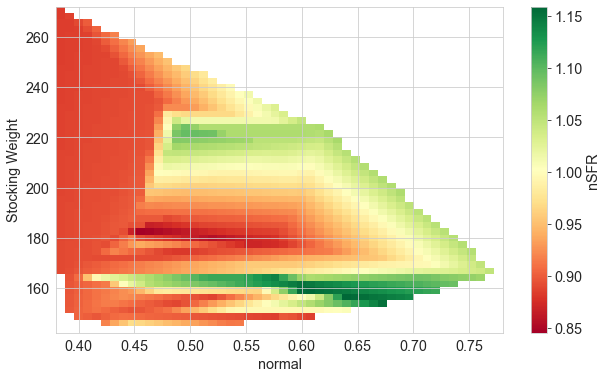

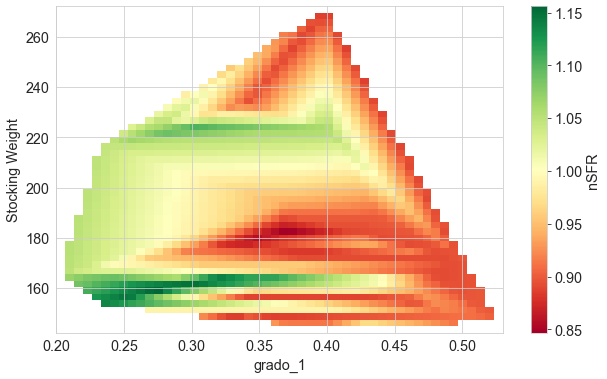

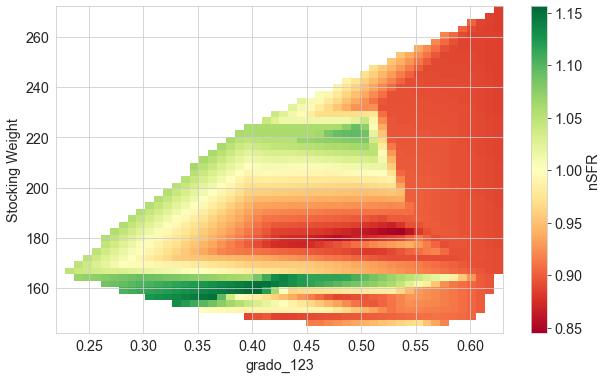

In [42]:
# factor = 'normal'
# for factor in ['normal','grado_1','cataratas','density']:
for factor in ['normal','grado_1','grado_123']:
    arr_for_3dchart_ = df_2022_[[factor,'stocking_weight','nsfr']].dropna()
    grid_step = 50
    arr_for_3dchart=arr_for_3dchart_.copy()
    # Extract data from DataFrame
    x = arr_for_3dchart[factor]
    y = arr_for_3dchart['stocking_weight']
    # y = arr_for_3dchart['ups_length-whole_period-mean']
    z = arr_for_3dchart['nsfr']

    # Define the grid based on x and y values
    x_grid, y_grid = np.meshgrid(np.linspace(x.min(), x.max(), grid_step), np.linspace(y.min(), y.max(), grid_step))

    # Calculate the average of mortality in each cell of the grid
    z_grid = griddata((x, y), z, (x_grid, y_grid), method='linear')
    average_mortality = np.mean(z_grid, axis=1)

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    heatmap = ax.imshow(z_grid, cmap="RdYlGn", extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')

    # Set labels for the axes
    ax.set_xlabel(f'{factor}')
    ax.set_ylabel('Stocking Weight')

    # Add colorbar
    cbar = fig.colorbar(heatmap, ax=ax)
    cbar.set_label('nSFR')

    # Show the plot
    # plt.show()
    plt.savefig(f'Visualisation\\sqi\\{factor}_vs_stocking_weight_vs_nSFR.png',dpi=300)

In [78]:
df.event_year.value_counts()

2022    96
2021     6
Name: event_year, dtype: int64

In [73]:
len(df_2022_)

41

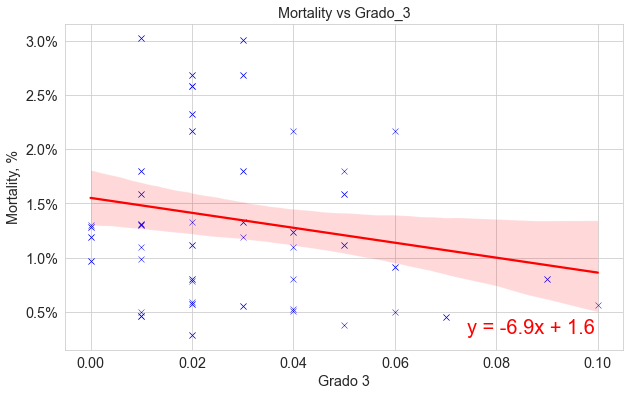

In [307]:
arr_for_chart = df__.copy()#[df__.grado_1>df__.grado_1.quantile(.05)]
# arr_for_chart = df__[df__.stocking_weight.between(140,180)]
arr_for_chart['mortality'] = arr_for_chart['mortality']*100
# Create the scatter plot with crosses as markers
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=arr_for_chart, x='grado_3', y='mortality', marker='x', color='blue')

# Add a trendline with equation
sns.regplot(data=arr_for_chart, x='grado_3', y='mortality', scatter=False, ax=scatter_plot, color='red', label='Trendline')

# Get the slope and intercept for the trendline
slope, intercept = np.polyfit(arr_for_chart['grado_3'], arr_for_chart['mortality'], 1)

# Add the equation to the plot
equation = f'y = {slope:.1f}x + {intercept:.1f}'
plt.text(0.95, 0.05, equation, fontsize=20, transform=plt.gca().transAxes, ha='right',c='red')

# Format y-axis as a percentage
def percent_formatter(x, pos):
    return f'{x:.1f}%'
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# # Set x-axis limits and ticks
# plt.xlim(0, 0.6)
# # plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])# Add labels and title

# # Extrapolate trendline beyond the range
# extrapolated_x = np.array([0, 0.6])  # Your desired extrapolation range
# extrapolated_y = extrapolated_x * slope + intercept
# plt.plot(extrapolated_x, extrapolated_y, color='purple', linestyle='dashed', label='Extrapolated Trendline')


plt.xlabel('Grado 3')
plt.ylabel('Mortality, %')
title = 'Mortality vs Grado_3'
plt.title(title)
# plt.legend()

plt.savefig(vis_path + title+ f'.png',dpi=300)

In [50]:
vis_path

'Visualisation\\sqi\\'

Text(0.5, 1.0, 'Mortality vs Grado_1')

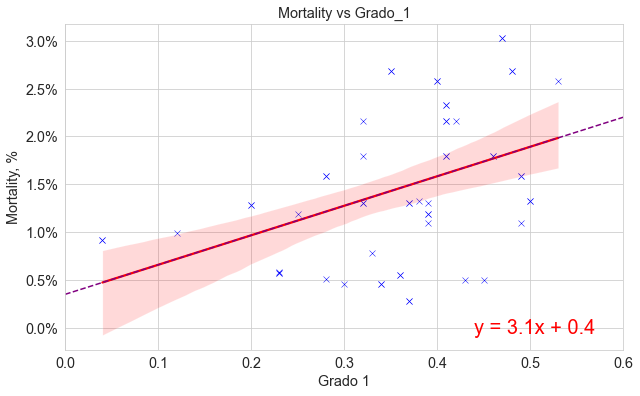

In [301]:
# stock weight doesn't affect a lot because this is around the same time stocking
# arr_for_chart = df__.copy()#[df__.grado_1>df__.grado_1.quantile(.05)]
# arr_for_chart = df__[df__.stocking_weight.between(140,180)]
# arr_for_chart['mortality'] = arr_for_chart['mortality']*100
# # Create the scatter plot with crosses as markers
# plt.figure(figsize=(10, 6))
# scatter_plot = sns.scatterplot(data=arr_for_chart, x='grado_1', y='mortality', marker='x', color='blue')

# # Add a trendline with equation
# sns.regplot(data=arr_for_chart, x='grado_1', y='mortality', scatter=False, ax=scatter_plot, color='red', label='Trendline')

# # Get the slope and intercept for the trendline
# slope, intercept = np.polyfit(arr_for_chart['grado_1'], arr_for_chart['mortality'], 1)

# # Add the equation to the plot
# equation = f'y = {slope:.1f}x + {intercept:.1f}'
# plt.text(0.95, 0.05, equation, fontsize=20, transform=plt.gca().transAxes, ha='right',c='red')

# # Format y-axis as a percentage
# def percent_formatter(x, pos):
#     return f'{x:.1f}%'
# plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# # Set x-axis limits and ticks
# plt.xlim(0, 0.6)
# # plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])# Add labels and title

# # Extrapolate trendline beyond the range
# extrapolated_x = np.array([0, 0.6])  # Your desired extrapolation range
# extrapolated_y = extrapolated_x * slope + intercept
# plt.plot(extrapolated_x, extrapolated_y, color='purple', linestyle='dashed', label='Extrapolated Trendline')


# plt.xlabel('Grado 1')
# plt.ylabel('Mortality, %')
# title = 'Mortality vs Grado_1'
# plt.title(title)
# # plt.legend()

# # plt.savefig(vis_path + title+ f'.png',dpi=300)

In [53]:
df_2022_[['grado_1','grado_2','grado_3','grado_123','normal']].corr()

,grado_1,grado_2,grado_3,grado_123,normal
grado_1,1.000000,-0.082628,-0.248120,0.822689,-0.820465
grado_2,-0.082628,1.000000,0.501337,0.464024,-0.459677
grado_3,-0.248120,0.501337,1.000000,0.217644,-0.224198
grado_123,0.822689,0.464024,0.217644,1.000000,-0.997651
normal,-0.820465,-0.459677,-0.224198,-0.997651,1.000000


In [52]:
df__

,event_date,locus_group,locus,fish_group,destino,density,cantidad_muestreada,normal,grado_1,grado_2,grado_3,cataratas,event_year,locus_id,grado_123,from_locus_id,transfer_year,mortality,nsfr,stocking_weight
0,2021-02-24,UPS1,102H,72G2103.SNFLY2000.C1.PH.LUF,Canal Piure,64.36,100,0.02,0.04,0.05,0.06,0.0,2021,3047787,0.15,3047787.0,2021.0,0.009150,0.887162,178.677998
1,2021-02-24,UPS1,102H,72G2103.SNFLY2000.C1.PH.LUF,Lamalec,64.36,100,0.02,0.04,0.05,0.06,0.0,2021,3047787,0.15,3047787.0,2021.0,0.009150,0.887162,178.677998
2,2021-02-24,UPS1,101M,NaN,NaN,NaN,100,0.15,0.12,0.03,0.01,0.0,2021,3046035,0.16,3046035.0,2021.0,0.009918,0.967669,171.708388
6,2022-03-07,UPS1,101H,72G2112.SNAQG2000.C4B.PH.FP,Puerto Argentino,54.44,101,0.38,0.40,0.18,0.05,0.0,2022,3047916,0.63,3047916.0,2022.0,0.003825,0.883538,272.000000
7,2022-04-07,UPS3,301M,72G2117.SNFLY2100.C2.PH,Puerto Argentino,47.00,103,0.38,0.49,0.10,0.04,0.0,2022,3048852,0.63,3048852.0,2022.0,0.010941,0.943125,176.537438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2022-08-23,UPS3,302,72G2205.SNLCY2100.C4.PH,Marilmo,14.86,103,0.68,0.23,0.07,0.02,0.0,2022,3049323,0.32,3049323.0,2022.0,0.005726,1.159756,153.000000
98,2022-08-23,UPS3,304,72G2202.SNLCY2100.C3B.PH,Loncochalgua,43.01,114,0.60,0.30,0.10,0.01,0.0,2022,3048387,0.41,3048387.0,2022.0,0.004591,1.151517,161.000000
99,2022-08-23,UPS3,307,72G2202.SNLCY2100.C3B.PH,Loncochalgua,46.27,113,0.58,0.23,0.09,0.10,0.0,2022,3051257,0.42,3051257.0,2022.0,0.005600,1.047410,216.893086
100,2022-08-23,UPS4,407H,72G2202.SNLCY2100.C3B.PH,Loncochalgua,46.72,113,0.43,0.42,0.10,0.04,0.0,2022,3049203,0.56,3049203.0,2022.0,0.021655,1.060425,162.917100


In [98]:
dftar[dftar.locus_id==3049323]

,locus_id,fish_group_id,transfer_year,stocking_weight,total_mortality_perc_90,transport_mortality_perc_90,nontransport_mortality_perc_90,TGC_SW,SGR_SW,sum_feed_90_kg,avg_weight_90days,stocking_count,close_count_90,close_weight_90,biomass_90_kg,biomass_stocking_kg,FCR_SW,SFR_SW,oSFR,nSFR


In [57]:
df_.describe()

,density,cantidad_muestreada,normal,grado_1,grado_2,grado_3,inflamados,opacidad_corneal,oerculo_corto,cataratas,locus_id,locus_group_id,site_id
count,90.000000,102.000000,102.000000,102.000000,102.000000,98.000000,7.000000,6.000000,6.000000,32.000000,1.020000e+02,99.000000,102.0
mean,41.802111,112.941176,0.502255,0.346961,0.088333,0.033265,0.071429,0.033333,0.043333,0.018750,3.169415e+06,557.272727,63858.0
std,14.974186,11.737073,0.110130,0.096982,0.046609,0.026155,0.060945,0.018619,0.044572,0.010701,6.983176e+05,1.615096,0.0
min,3.750000,100.000000,0.020000,0.040000,0.020000,0.000000,0.000000,0.010000,0.000000,0.010000,3.046035e+06,554.000000,63858.0
25%,31.722500,102.250000,0.450000,0.300000,0.060000,0.020000,0.010000,0.020000,0.020000,0.010000,3.047230e+06,556.000000,63858.0
50%,43.240000,112.000000,0.500000,0.360000,0.085000,0.030000,0.120000,0.035000,0.020000,0.015000,3.048194e+06,558.000000,63858.0
75%,52.467500,121.000000,0.550000,0.410000,0.110000,0.040000,0.120000,0.050000,0.080000,0.022500,3.049714e+06,558.000000,63858.0
max,64.360000,150.000000,0.780000,0.530000,0.240000,0.120000,0.120000,0.050000,0.100000,0.040000,7.184140e+06,560.000000,63858.0


In [37]:
df.columns

Index(['event_date', 'locus_group', 'locus', 'fish_group', 'destino',
       'density', 'cantidad_muestreada', 'normal', 'grado_1', 'grado_2',
       'grado_3', 'inflamados', 'opacidad_corneal', 'oerculo_corto',
       'cataratas'],
      dtype='object')

In [38]:
df.describe()

,density,cantidad_muestreada,normal,grado_1,grado_2,grado_3,inflamados,opacidad_corneal,oerculo_corto,cataratas
count,90.000000,102.000000,102.000000,102.000000,102.000000,98.000000,7.000000,6.000000,6.000000,32.000000
mean,41.802111,112.941176,0.502255,0.346961,0.088333,0.033265,0.071429,0.033333,0.043333,0.018750
std,14.974186,11.737073,0.110130,0.096982,0.046609,0.026155,0.060945,0.018619,0.044572,0.010701
min,3.750000,100.000000,0.020000,0.040000,0.020000,0.000000,0.000000,0.010000,0.000000,0.010000
25%,31.722500,102.250000,0.450000,0.300000,0.060000,0.020000,0.010000,0.020000,0.020000,0.010000
50%,43.240000,112.000000,0.500000,0.360000,0.085000,0.030000,0.120000,0.035000,0.020000,0.015000
75%,52.467500,121.000000,0.550000,0.410000,0.110000,0.040000,0.120000,0.050000,0.080000,0.022500
max,64.360000,150.000000,0.780000,0.530000,0.240000,0.120000,0.120000,0.050000,0.100000,0.040000


In [19]:
df[['event_date','locus_group','locus','destino','density','normal','grado_1','grado_2','grado_3','inflamados','']]

,event_date,site,locus_group,locus,fish_group,etapa_de_muestreo,destino,density,cantidad_muestreada,normal,grado_1,grado_2,grado_3,inflamados,opacidad_corneal,alteracion_operculo,oerculo_corto,cataratas
0,2021-02-24,UPS,UPS1,102H,72G2103.SNFLY2000.C1.PH.LUF,NaN,Canal Piure,64.36,100,0.02,0.04,0.05,0.06,0.00,0.02,NaN,0.10,NaN
1,2021-02-24,UPS,UPS1,102H,72G2103.SNFLY2000.C1.PH.LUF,NaN,Lamalec,64.36,100,0.02,0.04,0.05,0.06,0.00,0.02,NaN,0.10,NaN
2,2021-02-24,UPS,UPS1,101M,NaN,NaN,NaN,NaN,100,0.15,0.12,0.03,0.01,0.12,0.01,NaN,0.00,NaN
3,2021-06-15,UPS,UPS1,101,72G2104.SNLCY2000.C3.PH,NaN,Contao,3.75,100,0.45,0.13,0.24,0.12,0.12,0.05,NaN,0.02,0.01
4,2021-06-15,UPS,UPS1,101,72G2104.SNLCY2000.C3.PH,NaN,Manihueico,3.75,100,0.45,0.13,0.24,0.12,0.12,0.05,NaN,0.02,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2022-08-23,UPS,UPS3,302,72G2205.SNLCY2100.C4.PH,NaN,Marilmo,14.86,103,0.68,0.23,0.07,0.02,NaN,NaN,NaN,NaN,NaN
98,2022-08-23,UPS,UPS3,304,72G2202.SNLCY2100.C3B.PH,NaN,Loncochalgua,43.01,114,0.60,0.30,0.10,0.01,NaN,NaN,NaN,NaN,NaN
99,2022-08-23,UPS,UPS3,307,72G2202.SNLCY2100.C3B.PH,NaN,Loncochalgua,46.27,113,0.58,0.23,0.09,0.10,NaN,NaN,NaN,NaN,NaN
100,2022-08-23,UPS,UPS4,407H,72G2202.SNLCY2100.C3B.PH,NaN,Loncochalgua,46.72,113,0.43,0.42,0.10,0.04,NaN,NaN,NaN,NaN,NaN


In [18]:
df.dtypes

event_date             datetime64[ns]
site                           object
locus_group                    object
locus                          object
fish_group                     object
etapa_de_muestreo             float64
destino                        object
density                       float64
cantidad_muestreada             int64
normal                        float64
grado_1                       float64
grado_2                       float64
grado_3                       float64
inflamados                    float64
opacidad_corneal              float64
alteracion_operculo           float64
oerculo_corto                 float64
cataratas                     float64
dtype: object